# Head

In [2]:
import os
import logging
import json
import random
import numpy as np
import pandas as pd
from pandarallel import pandarallel

from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import (
    adjusted_mutual_info_score, 
    v_measure_score,
    adjusted_rand_score,
    fowlkes_mallows_score
)

from tqdm import tqdm
from typing import Dict, Tuple, Optional
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')


class TopicLabelConsistencyAnalyzer:
    def __init__(self, 
                 data_dir: str,
                 num_topics: int = 40,
                 passes: int = 1,
                 iterations: int = 50,
                 random_state: int = 42):
        """
        初始化主题标签一致性分析器
        """
        self.data_dir = data_dir
        self.num_topics = num_topics
        self.passes = passes
        self.iterations = iterations
        self.random_state = random_state
        
        # 数据存储
        self.df = None
        
        # 模型和词典
        self.dictionary = None
        self.lda_model = None
        
        # 结果存储
        self.topic_distributions = None
        self.consistency_metrics = {}
        
        # 标签方法映射
        self.label_to_method = {
            'kmeans_label': 'Periodical2Vec+$k$-means',
            # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
            # 'movmf_label': 'Periodical2Vec+movMF',
            # 'bert_kmeans_label': 'BERT+$k$-means',
            'cm_kmeans_label': 'Citation Matrix+$k$-means',
            'cm_n2v_kmeans_label': 'Node2Vec+$k$-means',
            'cocm_kmeans_label': 'CoCitation Matrix+$k$-means',
            'cocm_n2v_kmeans_label': 'CoCitation Node2Vec+$k$-means',
            # 'gnn_kmeans_label': 'GNN+$k$-means',
            'scopus_label': 'Scopus'
        }

        # 添加停用词相关
        self.stop_words = set(stopwords.words('english'))
        
        # 设置日志
        logging.basicConfig(
            format='%(asctime)s : %(levelname)s : %(message)s',
            level=logging.INFO
        )
        logging.getLogger('gensim').setLevel(logging.WARNING)

        pandarallel.initialize()


    def tokenize_abstracts(self, save_path: str = '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json', 
                           paper_id_path: str = '2010s/classification_tasks/abstracts/valid_PaperID.json', 
                           chunksize: int = 1e5) -> None:
            """
            对paper_abstracts.json文件进行tokenization，并保存为文件
            """
            abstracts_path = os.path.join(self.data_dir, 
                                        '2010s/classification_tasks/abstracts/paper_abstracts.json')
            save_path = os.path.join(self.data_dir, save_path)
            paper_id_path = os.path.join(self.data_dir, paper_id_path)

            logging.info("Tokenizing abstracts...")
            with open(save_path, 'w') as outfile, open(paper_id_path, 'w') as idfile:
                for chunk in tqdm(pd.read_json(abstracts_path, lines=True, chunksize=chunksize),
                                desc="Tokenizing abstracts", unit="chunk"):
                    chunk['abstract_lower'] = chunk['abstract'].str.lower()
                    chunk['tokens'] = chunk['abstract_lower'].parallel_apply(lambda abstract: [
                        token for token in word_tokenize(abstract)
                        if (len(token) > 2 and 
                            token not in self.stop_words and
                            token.isalnum())
                    ])
                    chunk = chunk.drop(columns=['abstract_lower', 'abstract'], errors='ignore')
                    chunk.to_json(outfile, orient='records', lines=True)
                    paper_ids = chunk['PaperID'].tolist()
                    for paper_id in paper_ids:
                        idfile.write(f"{paper_id}\n")
            
            logging.info(f"Tokenized abstracts saved to {save_path}")
            logging.info(f"Paper IDs saved to {paper_id_path}")


    def make_dictionary(self, 
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> None:
        """创建词典"""
        os.makedirs(save_dir, exist_ok=True)
        dict_path = os.path.join(save_dir, 'dict.id2word')
        # 检查词典文件是否存在
        if os.path.exists(dict_path):
            try:
                logging.info(f"找到已有词典文件，正在加载...")
                self.dictionary = Dictionary.load(dict_path)
                logging.info(f"词典加载成功")
                return
            except Exception as e:
                logging.warning(f"加载词典失败: {str(e)}")
                logging.warning("将重新创建词典")
        
        logging.info("开始创建新的词典...")
        # 创建词典
        self.dictionary = Dictionary()
        
        # 分批处理数据以创建词典
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        if os.path.exists(tokenized_path):
            logging.info(f"找到已处理的tokenized文件，正在加载: {tokenized_path}")
        else:
            logging.warning(f"未找到tokenized文件，将重新进行tokenization")
            self.tokenize_abstracts()
        
        for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e5),
                          desc="Creating dictionary", unit="chunk"):
            self.dictionary.add_documents(chunk['tokens'])
        self.dictionary.filter_extremes(no_below=5, no_above=0.5)
        
        # 保存词典
        self.dictionary.save(dict_path)
        logging.info(f"词典已保存到: {dict_path}")


    def analyze_vocabulary(self) -> Dict:
        """分析词汇统计信息"""
        if self.dictionary is None:
            raise ValueError("Dictionary not created yet. Run train_lda_model first.")
            
        vocab_stats = {
            'total_words': len(self.dictionary),
            'word_frequencies': sorted(
                [
                    (self.dictionary[id], freq)
                    for id, freq in self.dictionary.cfs.items()
                ],
                key=lambda x: x[1],
                reverse=True
            )[:50]  # 显示top 50词频
        }
        
        logging.info(f"词典大小: {vocab_stats['total_words']}")
        logging.info("Top 50 最常见的词:")
        for word, freq in vocab_stats['word_frequencies']:
            logging.info(f"{word}: {freq}")
            
        return vocab_stats


    def find_topics_num(self,
                        topic_numbers: range = range(20, 201, 20),
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency',
                        sample_ratio: float = 0.01  # 默认采样1%
                        ) -> Dict:
        """
        评估不同主题数量的模型表现，使用采样数据加速过程
        
        参数:
        topic_numbers: 要评估的主题数量范围
        save_dir: 保存结果的目录
        sample_ratio: 采样比例，默认为1%
        """
        results = []
        logging.info("开始评估不同主题数量...")
        
        # 创建保存目录
        os.makedirs(save_dir, exist_ok=True)
        results_file = os.path.join(save_dir, f'topic_number_results.csv')
        
        # 采样文件路径 - 使用JSON格式保存
        sample_path = os.path.join(save_dir, f'sampled_docs_{sample_ratio:.4f}.json')
        
        # 写入CSV头
        pd.DataFrame(columns=['num_topics', 'coherence']).to_csv(
            results_file, index=False
        )
        
        # Step 1: 获取采样数据
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        
        # 检查是否有已保存的采样
        sampled_docs = None
        if os.path.exists(sample_path):
            try:
                logging.info(f"找到已有采样文件，正在加载: {sample_path}")
                with open(sample_path, 'r', encoding='utf-8') as f:
                    sampled_docs = json.load(f)
                logging.info(f"成功加载{len(sampled_docs)}个采样文档")
            except Exception as e:
                logging.warning(f"加载采样文件失败: {str(e)}")
                sampled_docs = None
        
        # 如果没有找到采样文件或加载失败，创建新的采样
        if sampled_docs is None:
            logging.info(f"开始使用{sample_ratio:.1%}的采样率采样文档...")
            random.seed(self.random_state)  # 确保可重复性
            
            sampled_docs = []
            for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=int(1e6)),
                            desc="采样文档", unit="chunk"):
                # 对当前块进行采样
                chunk_sample = chunk.sample(frac=sample_ratio, random_state=self.random_state)
                
                # 提取需要的列
                for _, row in chunk_sample.iterrows():
                    sampled_docs.append({
                        'PaperID': row['PaperID'],
                        'tokens': row['tokens']
                    })
            
            logging.info(f"完成采样，共{len(sampled_docs)}个文档")
            
            # 保存采样结果到JSON文件
            try:
                with open(sample_path, 'w', encoding='utf-8') as f:
                    json.dump(sampled_docs, f)
                logging.info(f"采样结果已保存到: {sample_path}")
            except Exception as e:
                logging.warning(f"保存采样结果失败: {str(e)}")
        
        # 提取tokens用于coherence计算
        sampled_texts = [doc['tokens'] for doc in sampled_docs]
        
        # Step 2: 准备词典和语料库
        # 确保词典已创建
        if not hasattr(self, 'dictionary') or self.dictionary is None:
            self.make_dictionary()
        
        # 创建采样语料库
        logging.info(f"构建采样文档的语料库...")
        sampled_corpus = [self.dictionary.doc2bow(text) for text in sampled_texts]
        
        # Step 3: 评估所有主题数
        for num_topics in topic_numbers:
            self.num_topics = num_topics
            logging.info(f"\n评估主题数量: {num_topics}")
            
            # 使用采样语料库训练LDA模型
            self.lda_model = LdaModel(
                corpus=sampled_corpus,
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                eval_every=None,        # 禁用评估
                per_word_topics=False,  # 禁用词主题分布
            )
            
            # 计算coherence score
            coherence_model = CoherenceModel(
                model=self.lda_model,
                texts=sampled_texts,
                dictionary=self.dictionary,
                coherence='c_v',
                processes=8
            )
            
            coherence = coherence_model.get_coherence()
            
            result = {
                'num_topics': num_topics,
                'coherence': coherence,
            }
            results.append(result)
            
            # 实时保存结果
            pd.DataFrame([result]).to_csv(
                results_file, 
                mode='a', 
                header=False, 
                index=False
            )
            
        # 综合所有结果，确定最佳主题数
        results_df = pd.DataFrame(results)
        best_coherence_idx = results_df['coherence'].idxmax()
        best_topic_num = int(results_df.loc[best_coherence_idx, 'num_topics'])
        
        # 记录最佳主题数
        logging.info(f"找到最佳主题数: {best_topic_num}")
        self.num_topics = best_topic_num

        logging.info(f"最佳主题数量: {best_topic_num}, Coherence: {results_df.loc[best_coherence_idx, 'coherence']:.4f}")
        
        # 返回结果
        optimal_results = {
            'best_num_topics': best_topic_num,
            'best_coherence_score': results_df.loc[best_coherence_idx, 'coherence'],
            'all_results': results_df,
        }
        return optimal_results


    def train_lda_model(self, multicore=True, 
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> None:
        """训练LDA模型或加载已有模型"""
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            model_path = os.path.join(save_dir, f'lda_model_{self.num_topics}topics.model')
            
            # 检查模型文件是否存在
            if os.path.exists(model_path) :
                try:
                    logging.info(f"找到已有模型文件，正在加载...")
                    self.lda_model = LdaMulticore.load(model_path)
                    logging.info(f"模型加载成功：{model_path}")
                    return
                except Exception as e:
                    logging.warning(f"加载模型失败: {str(e)}")
                    logging.warning("将重新训练模型")
        
        logging.info("开始训练新的LDA模型...")
        
        self.make_dictionary()
        
        # 分批处理数据以训练LDA模型
        if multicore:
            self.lda_model = LdaMulticore(
                corpus=[],
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                workers=8,
                eval_every=None,        # 禁用评估
                per_word_topics=False,  # 禁用词主题分布
                batch=False,            # 禁用批处理
            )
        else:
            self.lda_model = LdaModel(
                corpus=[],
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                eval_every=None,        # 禁用评估
                per_word_topics=False,  # 禁用词主题分布
            )
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e6),
                          desc="Training LDA", unit="chunk"):
            corpus = [self.dictionary.doc2bow(text) for text in chunk['tokens']]
            self.lda_model.update(corpus)
        
        # 保存模型
        if save_dir:
            self.lda_model.save(model_path)
            logging.info(f"模型已保存到: {model_path}")


    def get_topic_distributions(self) -> np.ndarray:
        """获取文档-主题分布"""
        logging.info("Extracting topic distributions...")
        
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        num_docs = sum(1 for _ in open(tokenized_path, 'r'))  # 获取文档总数
        doc_topics = np.zeros((num_docs, self.num_topics))
        
        # 分批处理数据以获取文档-主题分布
        for i, chunk in enumerate(tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e5),
                                       desc="Extracting topic distributions", unit="chunk")):
            corpus = [self.dictionary.doc2bow(text) for text in chunk['tokens']]
            for j, bow in enumerate(corpus):
                topic_dist = self.lda_model.get_document_topics(bow, minimum_probability=0)
                for topic_id, prob in topic_dist:
                    doc_topics[i * int(1e5) + j, topic_id] = prob
        
        self.topic_distributions = doc_topics
        return doc_topics
    

    def prepare_dataset(self, dataset_path:str = '2010s/topic_consistency/dataset.parquet', 
                        paper_id_path: str = '2010s/classification_tasks/abstracts/valid_PaperID.json') -> pd.DataFrame:
        """
        Prepare a datafrmae, cols: PaperID, label1, label2, ...
        """
        dataset_path = os.path.join(self.data_dir, dataset_path)
        # 检查文件是否存在
        if os.path.exists(dataset_path):
            logging.info(f"找到已处理的数据集文件，正在加载: {dataset_path}")
            try:
                self.df = pd.read_parquet(dataset_path)
                logging.info("数据集加载成功")
                return self.df
            except Exception as e:
                logging.warning(f"加载数据集失败: {str(e)}")
                logging.warning("将重新处理数据集")

        paper_id_path = os.path.join(self.data_dir, paper_id_path)
        # 检查valid_PaperID.json文件是否存在
        if os.path.exists(paper_id_path):
            logging.info(f"找到已处理的PaperID list，正在加载: {paper_id_path}")
            try:
                # 加载PaperID
                with open(paper_id_path, 'r') as idfile:
                    paper_ids = [line.strip() for line in idfile]
            except Exception as e:
                logging.warning(f"加载PaperID list失败: {str(e)}")
                logging.warning("将重新进行tokenization")
                self.tokenize_abstracts()
                with open(paper_id_path, 'r') as idfile:
                    paper_ids = [line.strip() for line in idfile]
        
        logging.info('Preparing dataset...')
        self.df = pd.DataFrame({'PaperID': paper_ids})
        logging.info(f"Created DataFrame with {len(self.df)} rows")
        
        # 加载标签
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        logging.info("Loading label files...")
        
        # 预加载所有标签文件名，只处理JSON文件
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.json')]
        
        for label_file in label_files:
            label_name = label_file.replace('.json', '')
            logging.info(f"Loading {label_name}...")
            
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                label_set = json.load(f)
            
            self.df[label_name] = self.df['PaperID'].map(label_set)
        
        try:
            self.df.to_parquet(dataset_path)
            logging.info(f"数据集已保存到: {dataset_path}")
        except Exception as e:
            logging.warning(f"保存数据集失败: {str(e)}")
        
        return self.df


    def visualize_topic_label_matrix(self,
                                     label_type: str,
                                     metrics: Dict,
                                     save_dir: Optional[str] = None,
                                     figsize: Tuple[int, int] = (8, 8),
                                     cmap: str = 'YlOrRd',
                                     fmt: str = '.2f',
                                     cluster: bool = True) -> None:
        """
        可视化主题-标签矩阵，优化大规模主题和标签的显示
        """
        matrix = metrics['topic_label_matrix']
        
        # 使用clustermap并优化布局
        g = sns.clustermap(
            matrix,
            cmap=cmap,
            vmin=0,
            vmax=1,
            annot=False,
            fmt=fmt,
            figsize=figsize,
            xticklabels=False,  # 不显示x轴标签
            yticklabels=False,  # 不显示y轴标签
            row_cluster=True,
            col_cluster=True
        )
        
        # 调整标签大小和间距
        g.ax_heatmap.set_xlabel('Labels', fontsize=12)
        g.ax_heatmap.set_ylabel('Topics', fontsize=12)
        
        # 保存完整的聚类图
        if cluster and save_dir:
            filename = os.path.join(
                save_dir,
                f'topic_label_matrix_{label_type}.pdf'
            )
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            logging.info(f"聚类图已保存至: {filename}")


    def analyze_all_label_types(self, label_to_method: dict, 
                                save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> Dict:
        """分析所有标签类型"""
        if self.df is None:
            self.prepare_dataset()
            
        # 检查模型
        if self.lda_model is None:
            self.train_lda_model(save_dir)
        
        # 检查主题分布文件
        topic_dist_path = os.path.join(save_dir, f'topic_distributions_{self.num_topics}topics.npy')
        logging.info(f"主题分布文件路径: {topic_dist_path}")
        if os.path.exists(topic_dist_path):
            try:
                logging.info(f"找到已有主题分布文件，正在加载...")
                self.topic_distributions = np.load(topic_dist_path)
                logging.info(f"主题分布加载成功")
            except Exception as e:
                logging.warning(f"加载主题分布失败: {str(e)}")
                logging.warning("将重新计算主题分布")
                self.topic_distributions = None
        else:
            logging.info(f"未找到主题分布文件，将重新计算")
            self.topic_distributions = None
        
        # 计算主题分布
        if self.topic_distributions is None:
            logging.info("计算文档主题分布...")
            self.topic_distributions = self.get_topic_distributions()
            # 保存主题分布
            if topic_dist_path:
                np.save(topic_dist_path, self.topic_distributions)
                logging.info(f"主题分布已保存到: {topic_dist_path}")
        
        # 获取主题分配（只计算一次）
        topic_assignments = np.argmax(self.topic_distributions, axis=1)
        
        results = {}
        summary_data = []
        
        # 遍历每种标签类型进行分析
        for label_type in label_to_method.keys():
            logging.info(f"\nAnalyzing {label_type}...")
            
            # 获取标签
            labels = self.df[label_type].values
            
            # 计算各种一致性指标
            nmi = normalized_mutual_info_score(labels, topic_assignments)
            ami = adjusted_mutual_info_score(labels, topic_assignments)
            v_measure = v_measure_score(labels, topic_assignments)
            ari = adjusted_rand_score(labels, topic_assignments)
            fmi = fowlkes_mallows_score(labels, topic_assignments)
            
            # 计算主题-标签对应关系
            unique_labels = sorted(self.df[label_type].unique())
            topic_label_matrix = np.zeros((self.num_topics, len(unique_labels)))
            
            # 使用numpy的高效操作计算主题-标签矩阵
            for doc_idx, (topic_idx, label) in enumerate(zip(topic_assignments, labels)):
                label_idx = unique_labels.index(label)
                topic_label_matrix[topic_idx, label_idx] += 1
            
            # 标准化主题-标签矩阵
            row_sums = topic_label_matrix.sum(axis=1, keepdims=True)
            topic_label_matrix = np.divide(topic_label_matrix, row_sums, 
                                        where=row_sums!=0)
            
            # 存储结果
            metrics = {
                'normalized_mutual_information': nmi,
                'adjusted_mutual_information': ami,
                'v_measure': v_measure,
                'adjusted_rand_index': ari,
                'fowlkes_mallows_index': fmi,
                'topic_label_matrix': topic_label_matrix,
                'unique_labels': unique_labels
            }
            
            results[label_type] = metrics
            
            # 可视化并保存结果
            self.visualize_topic_label_matrix(label_type, metrics, save_dir)
            
            # 收集总结数据
            summary_data.append({
                'Label Type': label_to_method[label_type],
                'NMI': nmi,
                'AMI': ami,
                'V-measure': v_measure,
                'ARI': ari,
                'FMI': fmi
            })
        
        # 创建和保存总结表格
        summary_df = pd.DataFrame(summary_data)
        if save_dir:
            summary_df.to_csv(os.path.join(save_dir, 
                            f'consistency_metrics_summary.csv'),
                            index=False)
        
        return results

[nltk_data] Downloading package punkt to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zqlyu2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Neck

In [3]:
import sys
sys.path.append("periodical-clustering")

from utils import get_data_dir

In [4]:
# 初始化分析器
analyzer = TopicLabelConsistencyAnalyzer(
    data_dir=get_data_dir(),
    num_topics=30,
    passes=1,
    iterations=50)

data_dir:  /home/zqlyu2/projects/periodical-clustering/data
INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
analyzer.tokenize_abstracts()

2025-03-03 13:51:44,102 : INFO : Tokenizing abstracts...
Tokenizing abstracts: 234chunk [54:13, 13.91s/chunk]
2025-03-03 14:45:58,021 : INFO : Tokenized abstracts saved to /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json
2025-03-03 14:45:58,022 : INFO : Paper IDs saved to /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/valid_PaperID.json


In [5]:
analyzer.make_dictionary()

2025-03-03 14:47:08,071 : INFO : 开始创建新的词典...
2025-03-03 14:47:08,074 : INFO : 找到已处理的tokenized文件，正在加载: /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json
Creating dictionary: 0chunk [00:00, ?chunk/s]2025-03-03 14:47:12,014 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-03-03 14:47:12,540 : INFO : adding document #10000 to Dictionary<68011 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:13,117 : INFO : adding document #20000 to Dictionary<102726 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:13,683 : INFO : adding document #30000 to Dictionary<129659 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:14,262 : INFO : adding document #40000 to Dictionary<153816 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:14,912 : INFO : adding document #50000 to Dictionary<175428 unique to

In [6]:
analyzer.analyze_vocabulary()

2025-03-03 18:02:03,348 : INFO : 词典大小: 100000
2025-03-03 18:02:03,349 : INFO : Top 50 最常见的词:
2025-03-03 18:02:03,349 : INFO : patients: 11691646
2025-03-03 18:02:03,350 : INFO : study: 11626715
2025-03-03 18:02:03,350 : INFO : results: 10765830
2025-03-03 18:02:03,351 : INFO : using: 8644409
2025-03-03 18:02:03,351 : INFO : used: 6747422
2025-03-03 18:02:03,351 : INFO : data: 6710727
2025-03-03 18:02:03,352 : INFO : also: 6231295
2025-03-03 18:02:03,352 : INFO : analysis: 5904637
2025-03-03 18:02:03,352 : INFO : model: 5774283
2025-03-03 18:02:03,353 : INFO : two: 5485165
2025-03-03 18:02:03,354 : INFO : different: 5312745
2025-03-03 18:02:03,354 : INFO : high: 4921987
2025-03-03 18:02:03,354 : INFO : treatment: 4878479
2025-03-03 18:02:03,354 : INFO : cells: 4877777
2025-03-03 18:02:03,355 : INFO : method: 4731661
2025-03-03 18:02:03,355 : INFO : may: 4600748
2025-03-03 18:02:03,356 : INFO : methods: 4581235
2025-03-03 18:02:03,356 : INFO : based: 4491124
2025-03-03 18:02:03,357 : INF

{'total_words': 100000,
 'word_frequencies': [('patients', 11691646),
  ('study', 11626715),
  ('results', 10765830),
  ('using', 8644409),
  ('used', 6747422),
  ('data', 6710727),
  ('also', 6231295),
  ('analysis', 5904637),
  ('model', 5774283),
  ('two', 5485165),
  ('different', 5312745),
  ('high', 4921987),
  ('treatment', 4878479),
  ('cells', 4877777),
  ('method', 4731661),
  ('may', 4600748),
  ('methods', 4581235),
  ('based', 4491124),
  ('system', 4394096),
  ('compared', 4372402),
  ('time', 4289338),
  ('however', 4231099),
  ('group', 4216446),
  ('one', 4074017),
  ('use', 4022893),
  ('studies', 4004224),
  ('associated', 3912928),
  ('new', 3905461),
  ('abstract', 3841589),
  ('cell', 3835142),
  ('found', 3765059),
  ('significant', 3747378),
  ('showed', 3695566),
  ('effect', 3680245),
  ('higher', 3666776),
  ('effects', 3621166),
  ('increased', 3564709),
  ('research', 3513524),
  ('significantly', 3484698),
  ('paper', 3484136),
  ('control', 3422756),
  ('

# Finding optimal # of topic for LDA

In [5]:
# 评估最优主题数量
optimal_results = analyzer.find_topics_num(
    topic_numbers=range(10, 201, 10),
    sample_ratio=0.05,
    save_dir='/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency'
)

2025-03-08 19:30:54,461 : INFO : 开始评估不同主题数量...
2025-03-08 19:30:54,465 : INFO : 开始使用5.0%的采样率采样文档...
采样文档: 24chunk [09:51, 24.65s/chunk]
2025-03-08 19:40:45,955 : INFO : 完成采样，共1166122个文档
2025-03-08 19:41:13,574 : INFO : 采样结果已保存到: /home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency/sampled_docs_0.0500.json
2025-03-08 19:41:13,783 : INFO : 构建采样文档的语料库...
2025-03-08 19:41:59,071 : INFO : 
评估主题数量: 10
2025-03-08 19:47:13,489 : INFO : 
评估主题数量: 20
2025-03-08 19:53:54,134 : INFO : 
评估主题数量: 30
2025-03-08 20:03:38,011 : INFO : 
评估主题数量: 40
2025-03-08 20:23:42,825 : INFO : 
评估主题数量: 50
2025-03-08 20:45:11,971 : INFO : 
评估主题数量: 60
2025-03-08 21:11:12,129 : INFO : 
评估主题数量: 70
2025-03-08 21:54:34,264 : INFO : 
评估主题数量: 80
2025-03-08 23:19:33,475 : INFO : 
评估主题数量: 90
2025-03-09 00:41:59,317 : INFO : 
评估主题数量: 100
2025-03-09 01:26:43,742 : INFO : 
评估主题数量: 110
2025-03-09 02:11:51,958 : INFO : 
评估主题数量: 120
2025-03-09 02:57:28,865 : INFO : 
评估主题数量: 130
2025-03-09 03:40:50,000 : INFO : 
评估主题数量: 140

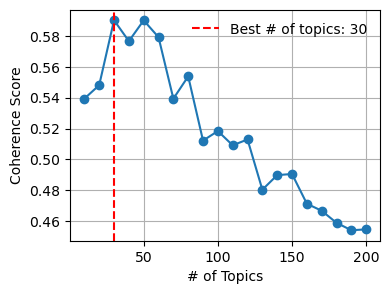

In [27]:
fig_file = os.path.join('/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency', f'coherence_scores.pdf')
results_df = pd.read_csv('/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency/topic_number_results.csv', index_col='num_topics')
best_topic_num = results_df.coherence.idxmax()

plt.figure(figsize=(4, 3))
plt.plot(results_df.index, results_df['coherence'], marker='o', linestyle='-',)
plt.axvline(x=best_topic_num, color='red', linestyle='--', label=f'Best # of topics: {best_topic_num}')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.legend(frameon=False)
plt.grid(True)
plt.savefig(fig_file, dpi=300, bbox_inches='tight')

# Training a (or loading a trained) LDA model

In [5]:
# 使用最优主题数量重新初始化分析器
analyzer.num_topics = 30
analyzer.train_lda_model(multicore=False, save_dir='periodical-clustering/data/2010s/topic_consistency')

2025-05-26 13:59:15,444 : INFO : 找到已有模型文件，正在加载...


2025-05-26 13:59:15,733 : INFO : 模型加载成功：periodical-clustering/data/2010s/topic_consistency/lda_model_30topics.model


In [6]:
# Print top 20 words for first 5 topics as examples
print("Example Topics from LDA Model:")
for topic_id in range(5):  # Show first 5 topics
    # Get the top 20 words for this topic
    top_words = [word for word, _ in analyzer.lda_model.show_topic(topic_id, topn=20)]
    print(f"\nTopic {topic_id}:")
    # Display 5 words per line
    for i in range(0, len(top_words), 5):
        print(", ".join(top_words[i:i+5]))

Example Topics from LDA Model:

Topic 0:
surface, two, velocity, flow, formation
along, depth, length, layer, within
region, vertical, thickness, zone, angle
field, large, distance, position, area

Topic 1:
soil, plant, content, plants, growth
production, water, study, yield, higher
total, showed, increased, different, organic
biomass, treatment, results, iron, concentrations

Topic 2:
water, species, areas, data, area
changes, climate, study, population, change
period, region, china, may, sites
high, spatial, distribution, environmental, years

Topic 3:
fiber, fibers, 2010, 2011, 2012
dental, 2013, wiley, silica, 2014
annealing, oral, copyright, 2015, cutting
2009, van, john, teeth, reserved

Topic 4:
cells, cell, expression, protein, role
human, proteins, mice, activation, signaling
also, receptor, activity, pathway, growth
mechanisms, cellular, results, response, function


# Consistency analysis

In [9]:
analyzer.prepare_dataset()

2025-05-26 14:05:57,532 : INFO : 找到已处理的PaperID list，正在加载: /home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/abstracts/valid_PaperID.json
2025-05-26 14:06:00,566 : INFO : Preparing dataset...
2025-05-26 14:06:01,915 : INFO : Created DataFrame with 23322430 rows
2025-05-26 14:06:01,916 : INFO : Loading label files...
2025-05-26 14:06:01,917 : INFO : Loading cocm_n2v_kmeans_label...
2025-05-26 14:07:11,793 : INFO : Loading cm_n2v_kmeans_label...
2025-05-26 14:08:20,539 : INFO : Loading gnn_kmeans_label...
2025-05-26 14:09:29,828 : INFO : Loading scopus_label...
2025-05-26 14:10:51,915 : INFO : Loading cm_kmeans_label...
2025-05-26 14:12:01,725 : INFO : Loading skm_label...
2025-05-26 14:13:15,395 : INFO : Loading kmeans_label...
2025-05-26 14:14:25,719 : INFO : Loading bert_kmeans_label...
2025-05-26 14:15:39,309 : INFO : Loading cocm_kmeans_label...
2025-05-26 14:16:49,252 : INFO : Loading movmf_label...
2025-05-26 14:18:15,007 : INFO : 数据集已保存到: /home/zqlyu2/pro

,PaperID,cocm_n2v_kmeans_label,cm_n2v_kmeans_label,gnn_kmeans_label,scopus_label,cm_kmeans_label,skm_label,kmeans_label,bert_kmeans_label,cocm_kmeans_label,movmf_label
0,2055207701,11,2,8,Agricultural and Biological Sciences,1,17,8,13,25,13
1,2055207717,11,1,11,Medicine,23,14,7,15,16,15
2,2055207742,2,25,5,Social Sciences,1,25,23,24,1,19
3,2055207772,2,10,11,Medicine,7,8,22,21,15,8
4,2055207790,11,20,0,Immunology and Microbiology,4,23,16,13,8,22
...,...,...,...,...,...,...,...,...,...,...,...
23322425,2726882176,8,3,0,Multidisciplinary,21,20,17,0,8,22
23322426,2726882179,2,22,12,Social Sciences,1,4,24,16,12,2
23322427,2726882219,5,4,2,Materials Science,6,12,14,9,23,23
23322428,2726882240,2,25,12,"Business, Management and Accounting",1,4,1,16,12,2


2025-05-26 14:19:56,384 : INFO : 主题分布文件路径: periodical-clustering/data/2010s/topic_consistency/topic_distributions_30topics.npy
2025-05-26 14:19:56,385 : INFO : 找到已有主题分布文件，正在加载...


2025-05-26 14:19:58,369 : INFO : 主题分布加载成功
2025-05-26 14:19:59,817 : INFO : 
Analyzing kmeans_label...
2025-05-26 14:21:38,868 : INFO : 聚类图已保存至: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_kmeans_label.pdf
2025-05-26 14:21:38,870 : INFO : 
Analyzing cm_kmeans_label...
2025-05-26 14:23:24,168 : INFO : 聚类图已保存至: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cm_kmeans_label.pdf
2025-05-26 14:23:24,169 : INFO : 
Analyzing cm_n2v_kmeans_label...
2025-05-26 14:25:05,121 : INFO : 聚类图已保存至: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cm_n2v_kmeans_label.pdf
2025-05-26 14:25:05,123 : INFO : 
Analyzing cocm_kmeans_label...
2025-05-26 14:26:44,771 : INFO : 聚类图已保存至: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cocm_kmeans_label.pdf
2025-05-26 14:26:44,772 : INFO : 
Analyzing cocm_n2v_kmeans_label...
2025-05-26 14:28:24,992 : INFO : 聚类图已保存至: periodical-clustering/data/2010s/topic_consistency/topic_labe

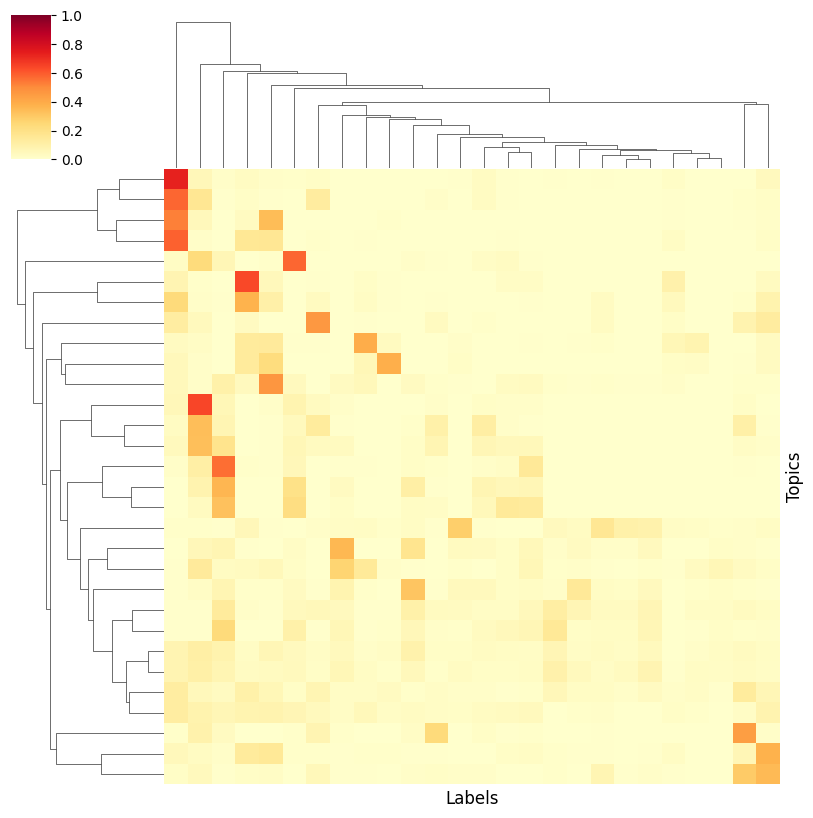

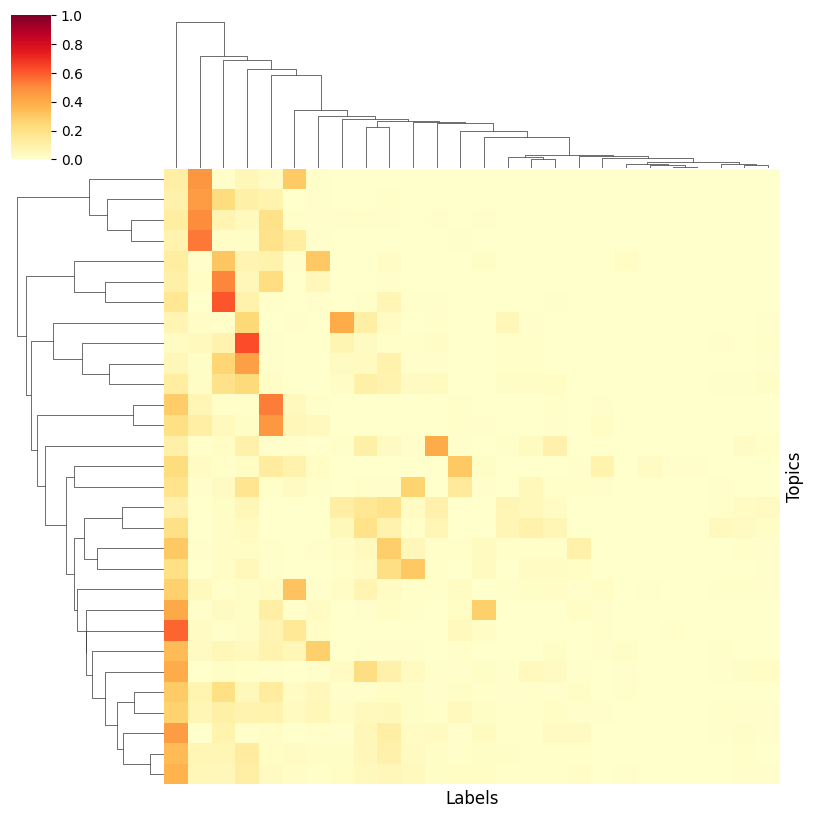

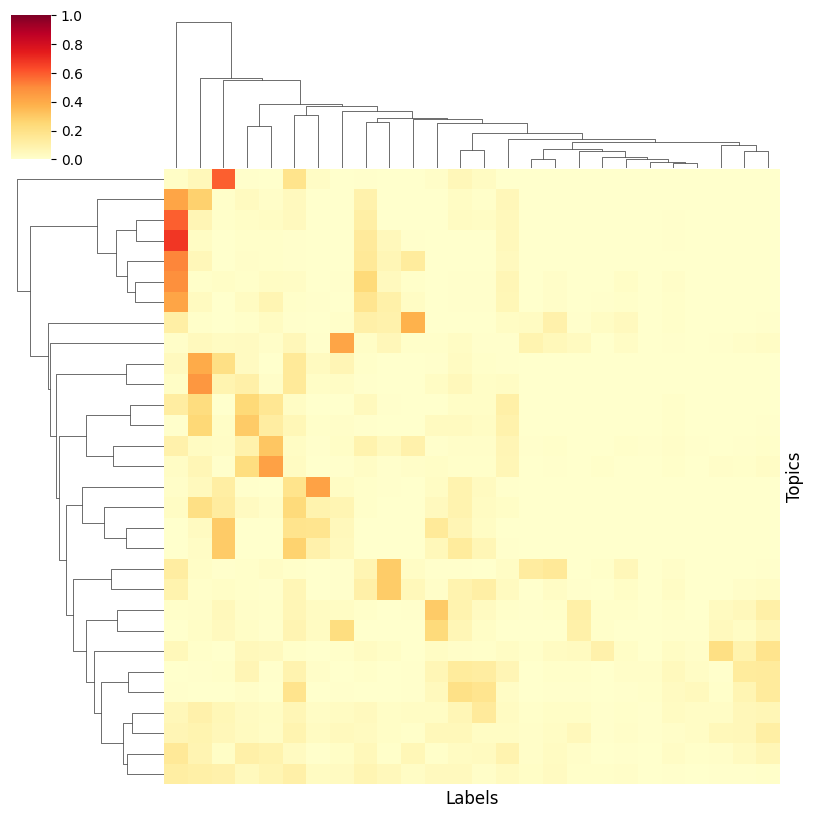

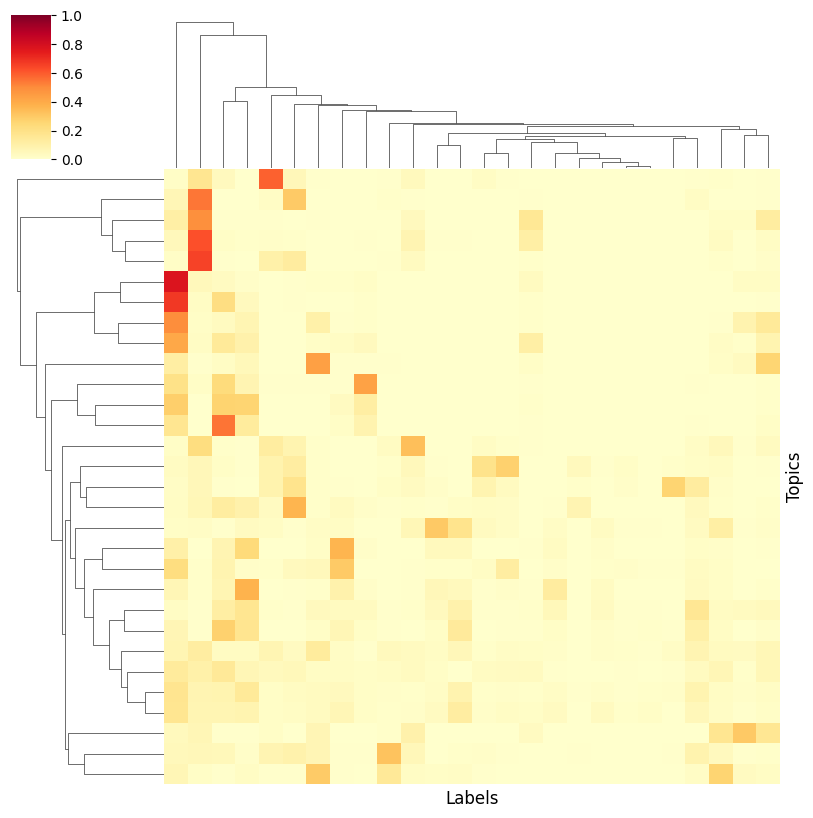

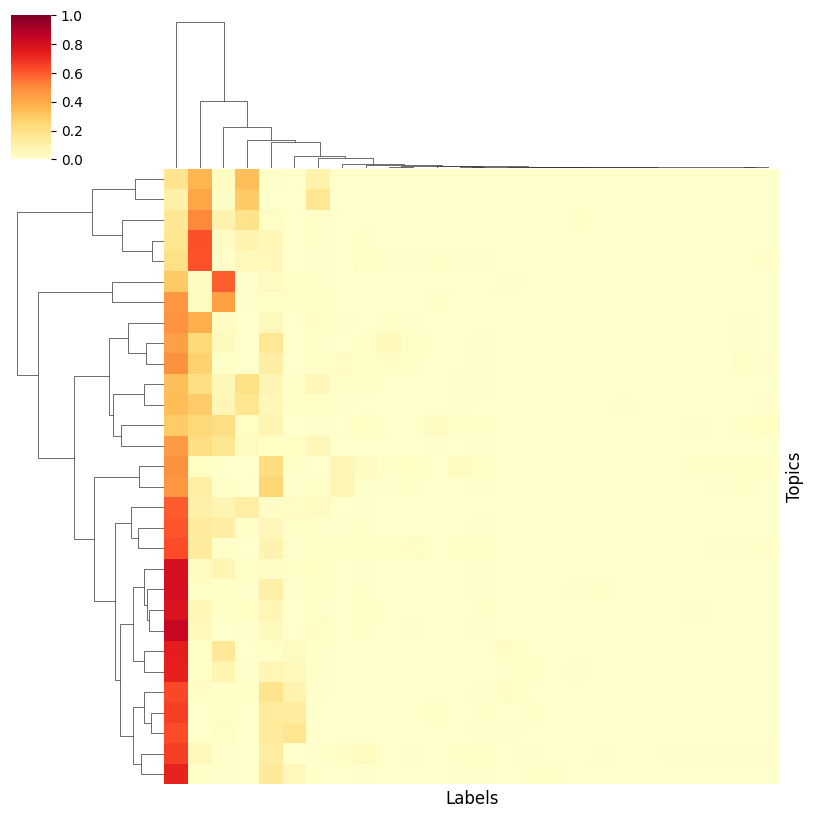

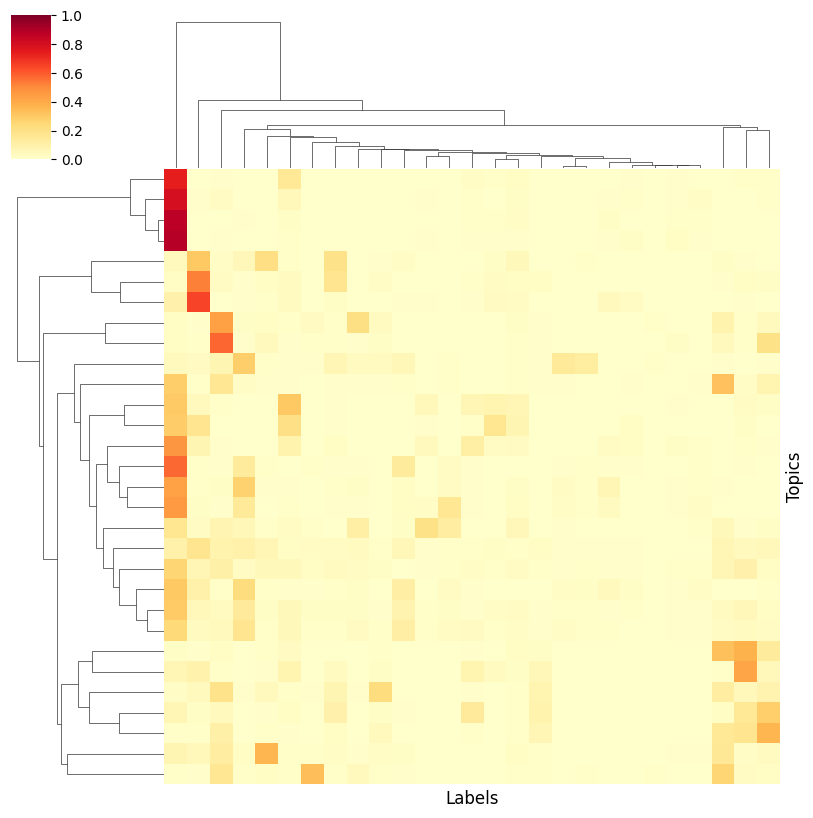

In [10]:
# 分析所有标签类型
label_to_method = {
            'kmeans_label': 'Periodical2Vec+$k$-means',
            # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
            # 'movmf_label': 'Periodical2Vec+movMF',
            # 'bert_kmeans_label': 'BERT+$k$-means',
            'cm_kmeans_label': 'Citation Matrix+$k$-means',
            'cm_n2v_kmeans_label': 'Node2Vec+$k$-means',
            'cocm_kmeans_label': 'Co-Citation Matrix+$k$-means',
            'cocm_n2v_kmeans_label': 'Co-Citation Node2Vec+$k$-means',
            # 'gnn_kmeans_label': 'GNN+$k$-means',
            'scopus_label': 'Scopus'
        }
results = analyzer.analyze_all_label_types(label_to_method)

In [11]:
# 查看特定标签类型的结果
for label_type, metrics in results.items():
    print(f"\n{analyzer.label_to_method[label_type]}的一致性指标:")
    print(f"标准化互信息: {metrics['normalized_mutual_information']:.4f}")
    print(f"调整兰德指数: {metrics['adjusted_rand_index']:.4f}")
    print(f"Fowlkes-Mallows指数: {metrics['fowlkes_mallows_index']:.4f}")
    


Periodical2Vec+$k$-means的一致性指标:
标准化互信息: 0.3195
调整兰德指数: 0.1693
Fowlkes-Mallows指数: 0.2169

Citation Matrix+$k$-means的一致性指标:
标准化互信息: 0.2662
调整兰德指数: 0.1127
Fowlkes-Mallows指数: 0.1804

Node2Vec+$k$-means的一致性指标:
标准化互信息: 0.2748
调整兰德指数: 0.1306
Fowlkes-Mallows指数: 0.1816

CoCitation Matrix+$k$-means的一致性指标:
标准化互信息: 0.3168
调整兰德指数: 0.1633
Fowlkes-Mallows指数: 0.2203

CoCitation Node2Vec+$k$-means的一致性指标:
标准化互信息: 0.1672
调整兰德指数: 0.0324
Fowlkes-Mallows指数: 0.1631

Scopus的一致性指标:
标准化互信息: 0.3010
调整兰德指数: 0.1371
Fowlkes-Mallows指数: 0.2106
